In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import copy
from torch.nn.modules import Module
from torch import Tensor
from torch import nn as nn
import math
from transformers import BertForSequenceClassification, BertTokenizer, AutoTokenizer, AutoModelForPreTraining
from model.transformer import tiny_transformer_with_3_layers, bert_base_uncased_model
from model.utils import load_pretrained_weights

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats as st
from datasets import load_dataset
from itertools import product
import dgl
import networkx as nx

/home/farnoush/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/farnoush/venv/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/farnoush/venv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Visualization Code

In [3]:
from visualization.utils import rescale_score_by_abs, getRGB, span_word, html_heatmap, \
make_text_string, make_color #vis_tree_heat


## XAI Utils

In [4]:
# from explanation import symb_xai, lrp, HOExplainer

In [5]:
from lrp.symbolic_xai import TransformerSymbXAI, BERTSymbXAI


## BERT model with 3 layers

In [ ]:
# Create model.
model = tiny_transformer_with_3_layers(
    pretrained_model_name_or_path="textattack/bert-base-uncased-SST-2"
)
pretrained_embeddings = model.bert.embeddings

# Load pre-trained weights.
load_pretrained_weights(
    model,
    '/home/farnoush/fairness//sst2-3layer-model.pt'
)


## BERT model with 12 layers

In [6]:
# Create model.
model = bert_base_uncased_model(
    pretrained_model_name_or_path='textattack/bert-base-uncased-SST-2'
)
model.eval()
pretrained_embeddings = model.bert.embeddings

## Explain tiny BERT model on the SST2 dataset

In [7]:
from dgl.data import SSTDataset

mode =  'treebank' # 'treebank' 
if mode == 'huggingface':
    # Load SST2 dataset.
    dataset = load_dataset("sst2", "default")
if mode == 'treebank':
    dataset = SSTDataset(mode='train')
    vocab_words = list(dataset.vocab.keys())


In [8]:
def process_treeid2tokenid(indices, mask, tokens, lsent, verbose=False):
    assert len(mask.nonzero()) == len(lsent), f'len(mask.nonzero()) = {len(mask.nonzero())} != {len(lsent)} = len(indices) '
    cls_id = 0
    sep_id = len(tokens)-1
    
    wordInd2token = {}
    curr_tid = 1 # start with the first token
    for word_tid in range(len(lsent)):
        if tokens[curr_tid] == lsent[word_tid]: 
            wordInd2token[word_tid] = [curr_tid]
            curr_tid += 1
            continue
        else:
            word_string = tokens[curr_tid].replace('##', '')
            tids = [curr_tid]
            while word_string != lsent[word_tid]:
                curr_tid += 1
                word_string += tokens[curr_tid].replace('##', '')
                tids.append(curr_tid)
                if curr_tid == sep_id : 
                    raise RuntimeError(f'Not possible to parse {tokens} into {lsent}')
            
            wordInd2token[word_tid] = tids
            curr_tid += 1
        
    if verbose: print(wordInd2token)
        
    token_indices = []
    for ind in indices:
        word_ids = list(mask.nonzero().squeeze().numpy())
        if ind in word_ids:
            token_indices += wordInd2token[word_ids.index(ind)]
    
    return token_indices

# Plot a few data samples

In [9]:
import dgl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from visualization.utils import make_color


tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")
embeddings = model.bert.embeddings

label2sent_symb = {0:'--', 1: '-', 2:'0', 3: '+', 4:'++'}


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import copy
import dgl
from networkx.drawing.nx_agraph import graphviz_layout

In [11]:
def vis_tree_heat(tree, node_heat, vocab_words, node_labels=None, save_dir=None, word_dist=40, node_size=2000):
    fig, ax = plt.subplots(figsize=[24, 16], dpi=150)
    # fig, ax = plt.subplots(figsize=[12, 8], dpi=150)

    G = dgl.to_networkx(tree)
    G = G.to_undirected()
    pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
    pos = {int(k): v for k, v in pos.items()}
    print(pos)

    # nodes
    nx.draw_networkx_nodes(G,
                           pos,
                           node_color=node_heat,
                           edgecolors='black',
                           node_size=node_size,
                           ax=ax)

    # labels
    if node_labels is not None:
        nx.draw_networkx_labels(G, pos,
                                labels=node_labels,
                                font_size=25, ax=ax)

    # edges
    nx.draw_networkx_edges(G, pos, ax=ax)

    # words
    mask = tree.ndata['mask']
    leaf_nodes = mask.nonzero().squeeze().numpy()
    pos_ = copy.copy(pos)

    for ln in leaf_nodes: pos_[ln] = (pos_[ln][0], pos_[ln][1] - word_dist)

    input_ids = tree.ndata['x']
    nx.draw_networkx_labels(G, pos_,
                            labels={ln: vocab_words[idw] for ln, idw in zip(leaf_nodes, input_ids[mask == 1])},
                            font_size=25, ax=ax)

    
    ax.set_axis_off()
    plt.tight_layout()
    plt.margins(y=.1, x=.0)

    if save_dir is not None:
        plt.savefig(save_dir, transparent=True)
        
    plt.show()

In [17]:
# plot ground truth
sid = 5004
# sid = 7
tree = dataset[sid]
input_ids = tree.ndata['x'] # word id of the node
labels = tree.ndata['y'] #  label of the node
mask = tree.ndata['mask']
lsent =  [vocab_words[idw] for idw in input_ids[mask == 1]]
sentence =  make_text_string(lsent)
sample = tokenizer(sentence, return_tensors="pt")
words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
    


node_labels = {i:label2sent_symb[int(label)] for i,label in enumerate(labels)}

node_heat = [make_color( (float(label) - 2.)/3.) for label in labels]

In [18]:
print(labels[0])
lsent

tensor(1)


['a',
 'pathetically',
 'inane',
 'and',
 'unimaginative',
 'cross',
 'between',
 'xxx',
 'and',
 'vertical',
 'limit',
 '.']

In [19]:
mask

tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1])

/tmp/ipykernel_1213642/880882041.py:11: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog="dot")


(-34.92000000000001, 574.9200000000001)


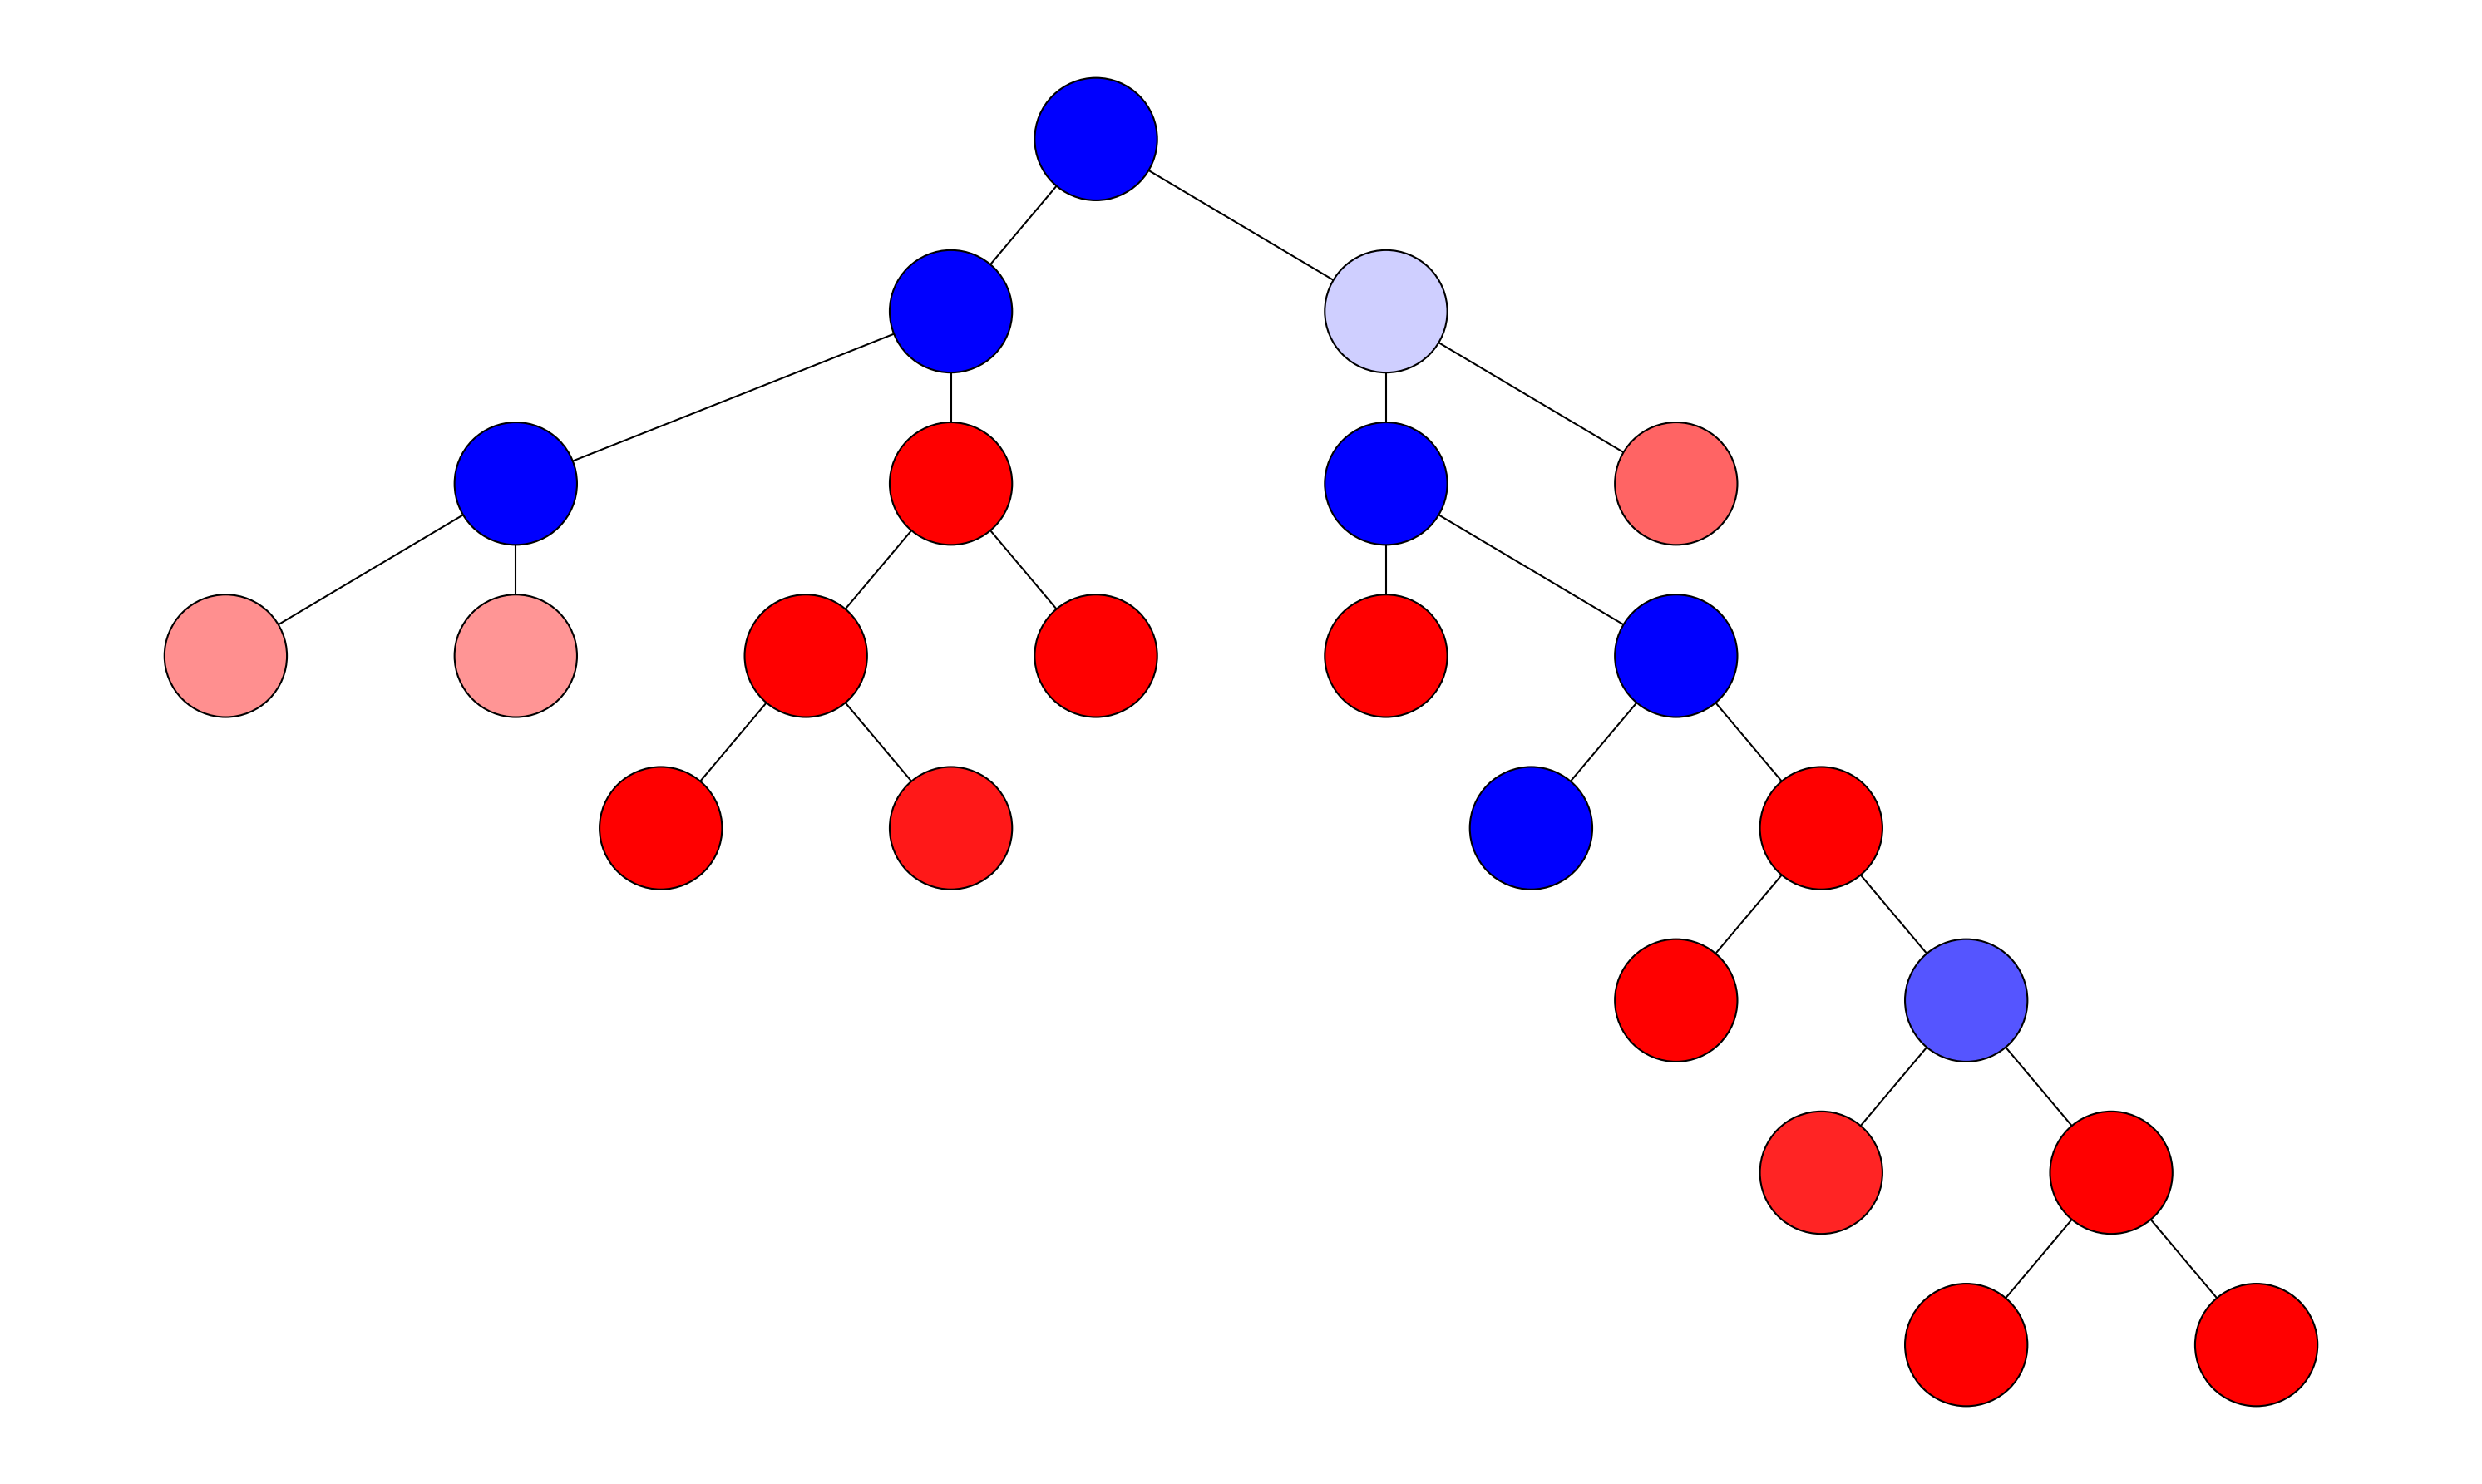

In [40]:
node_size = 5000 #3000
word_dist = 30
save_dir=None
node_labels = None

# fig, ax = plt.subplots(figsize=[12, 8], dpi=150)
fig = plt.figure(1, figsize=[20, 12], dpi=150)

G = dgl.to_networkx(tree)
G = G.to_undirected()
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
# pos = nx.get_node_attributes(G, "pos")
# offset_pos = 20
# pos = {k: (v[0], v[1] + offset_pos) for k, v in pos.items()}


offset = 0 #-5
pos_edge = copy.copy(pos)
pos_edge = {k: (v[0] + offset, v[1]) for k, v in pos_edge.items()}

xs = []
ys = []
for k in pos_edge.keys():
    v = pos_edge[k]
    xs.append(v[0])
    ys.append(v[1])
    

if False:
    # words
    mask = tree.ndata['mask']
    leaf_nodes = mask.nonzero().squeeze().numpy()
    pos_ = copy.copy(pos)

    for ln in leaf_nodes: pos_[ln] = (pos_[ln][0], pos_[ln][1] - word_dist)
    print(pos_)

    input_ids = tree.ndata['x']
    labels={ln: vocab_words[idw] for ln, idw in zip(leaf_nodes, input_ids[mask == 1])}
    print(labels)
    nx.draw_networkx_labels(G, 
                            pos_,
                            labels=labels,
                            font_size=16, clip_on=False)

# nodes
nx.draw_networkx_nodes(G,
                       pos,
                       node_color=node_heat,
                       edgecolors='black',
                       node_size=node_size, node_shape='o')

# labels
if node_labels is not None:
    nx.draw_networkx_labels(G, pos,
                            labels=node_labels,
                            font_size=30, width=2)

# edges
nx.draw_networkx_edges(G, pos_edge)

# ax.set_axis_off()
# ax.set_in_layout(False)
plt.axis('off')
print(plt.ylim())
# plt.ylim(0, plt.ylim()[1]+30)

plt.tight_layout()
plt.savefig("/home/farnoush/symbolicXAI/figures/shap_sst_qualitative1_sub.png", bbox_inches='tight', transparent=True)
# plt.show()

/tmp/ipykernel_1341228/161965783.py:7: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog="dot")


{0: (243.0, 522.0), 1: (207.0, 450.0), 2: (99.0, 378.0), 3: (27.0, 306.0), 4: (99.0, 306.0), 5: (207.0, 378.0), 6: (171.0, 306.0), 7: (135.0, 234.0), 8: (207.0, 234.0), 9: (243.0, 306.0), 10: (315.0, 450.0), 11: (315.0, 378.0), 12: (315.0, 306.0), 13: (387.0, 306.0), 14: (351.0, 234.0), 15: (423.0, 234.0), 16: (387.0, 162.0), 17: (459.0, 162.0), 18: (423.0, 90.0), 19: (495.0, 90.0), 20: (459.0, 18.0), 21: (531.0, 18.0), 22: (387.0, 378.0)}


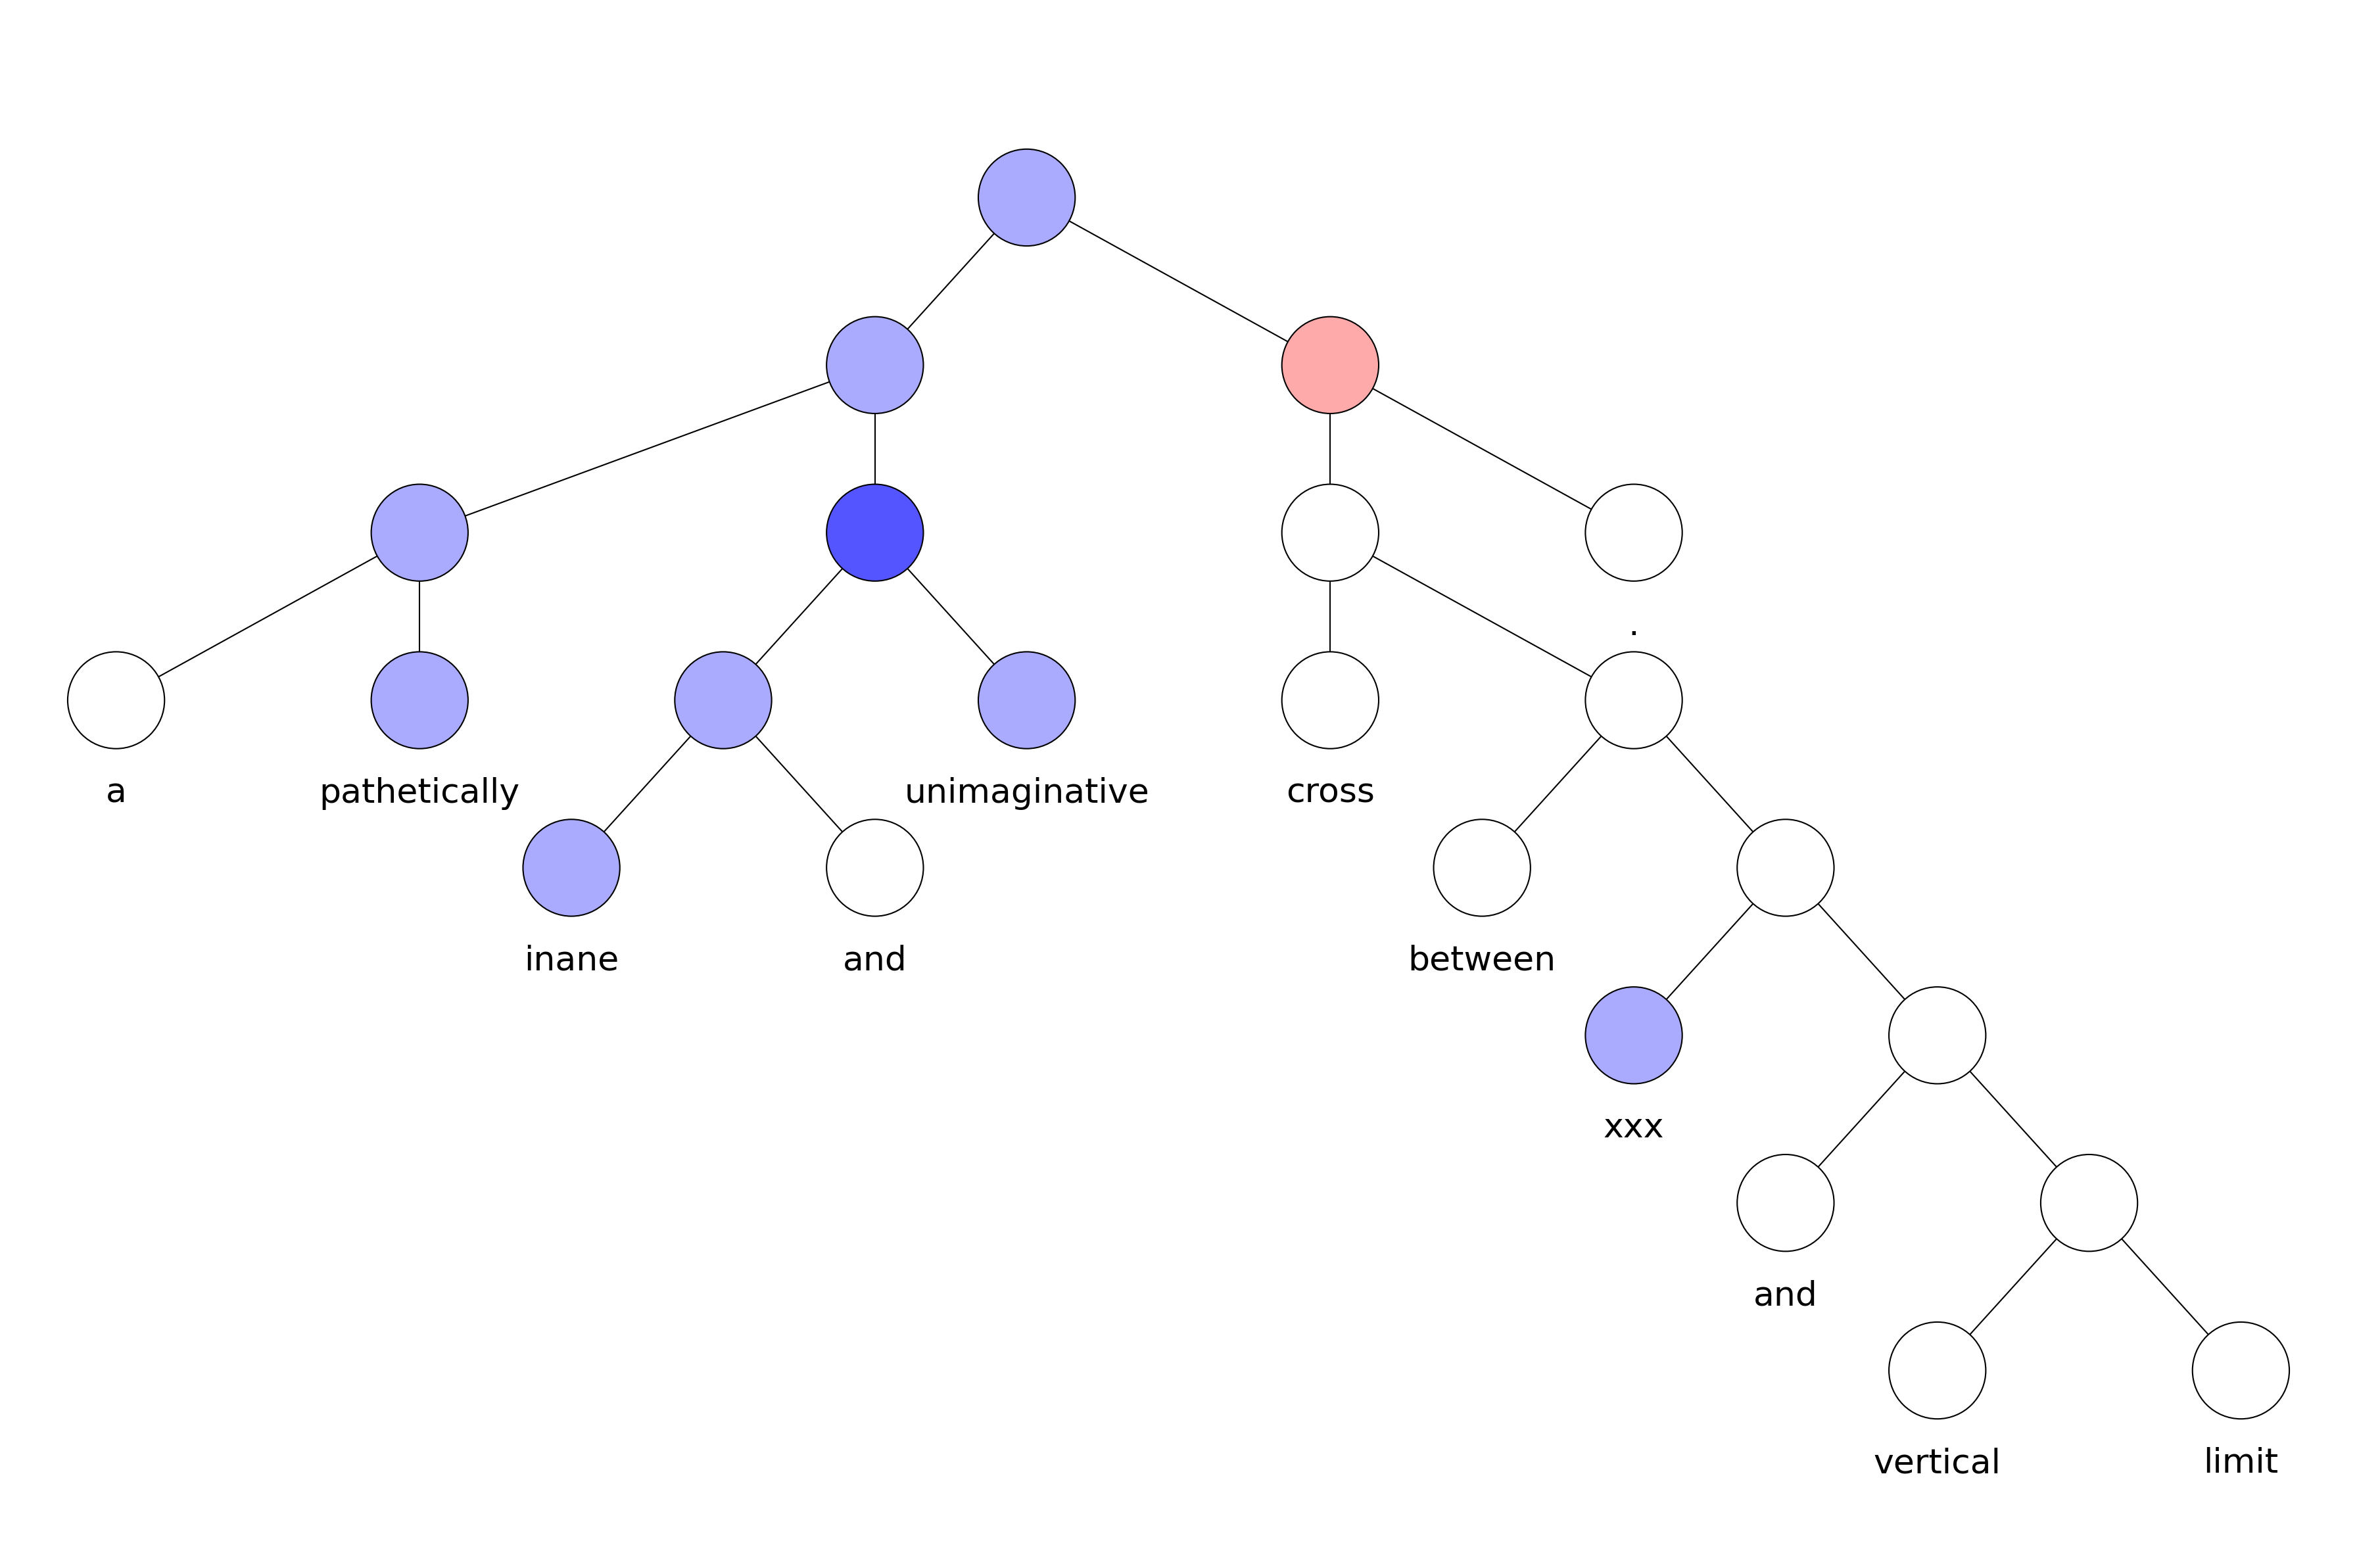

In [20]:
vis_tree_heat(tree, node_heat, vocab_words, node_labels=None, 
              save_dir='/home/farnoush/symbolicXAI/figures/sst_qualitative2.png',
             node_size=5000)

/tmp/ipykernel_1341228/161965783.py:7: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog="dot")


{0: (243.0, 522.0), 1: (207.0, 450.0), 2: (99.0, 378.0), 3: (27.0, 306.0), 4: (99.0, 306.0), 5: (207.0, 378.0), 6: (171.0, 306.0), 7: (135.0, 234.0), 8: (207.0, 234.0), 9: (243.0, 306.0), 10: (315.0, 450.0), 11: (315.0, 378.0), 12: (315.0, 306.0), 13: (387.0, 306.0), 14: (351.0, 234.0), 15: (423.0, 234.0), 16: (387.0, 162.0), 17: (459.0, 162.0), 18: (423.0, 90.0), 19: (495.0, 90.0), 20: (459.0, 18.0), 21: (531.0, 18.0), 22: (387.0, 378.0)}


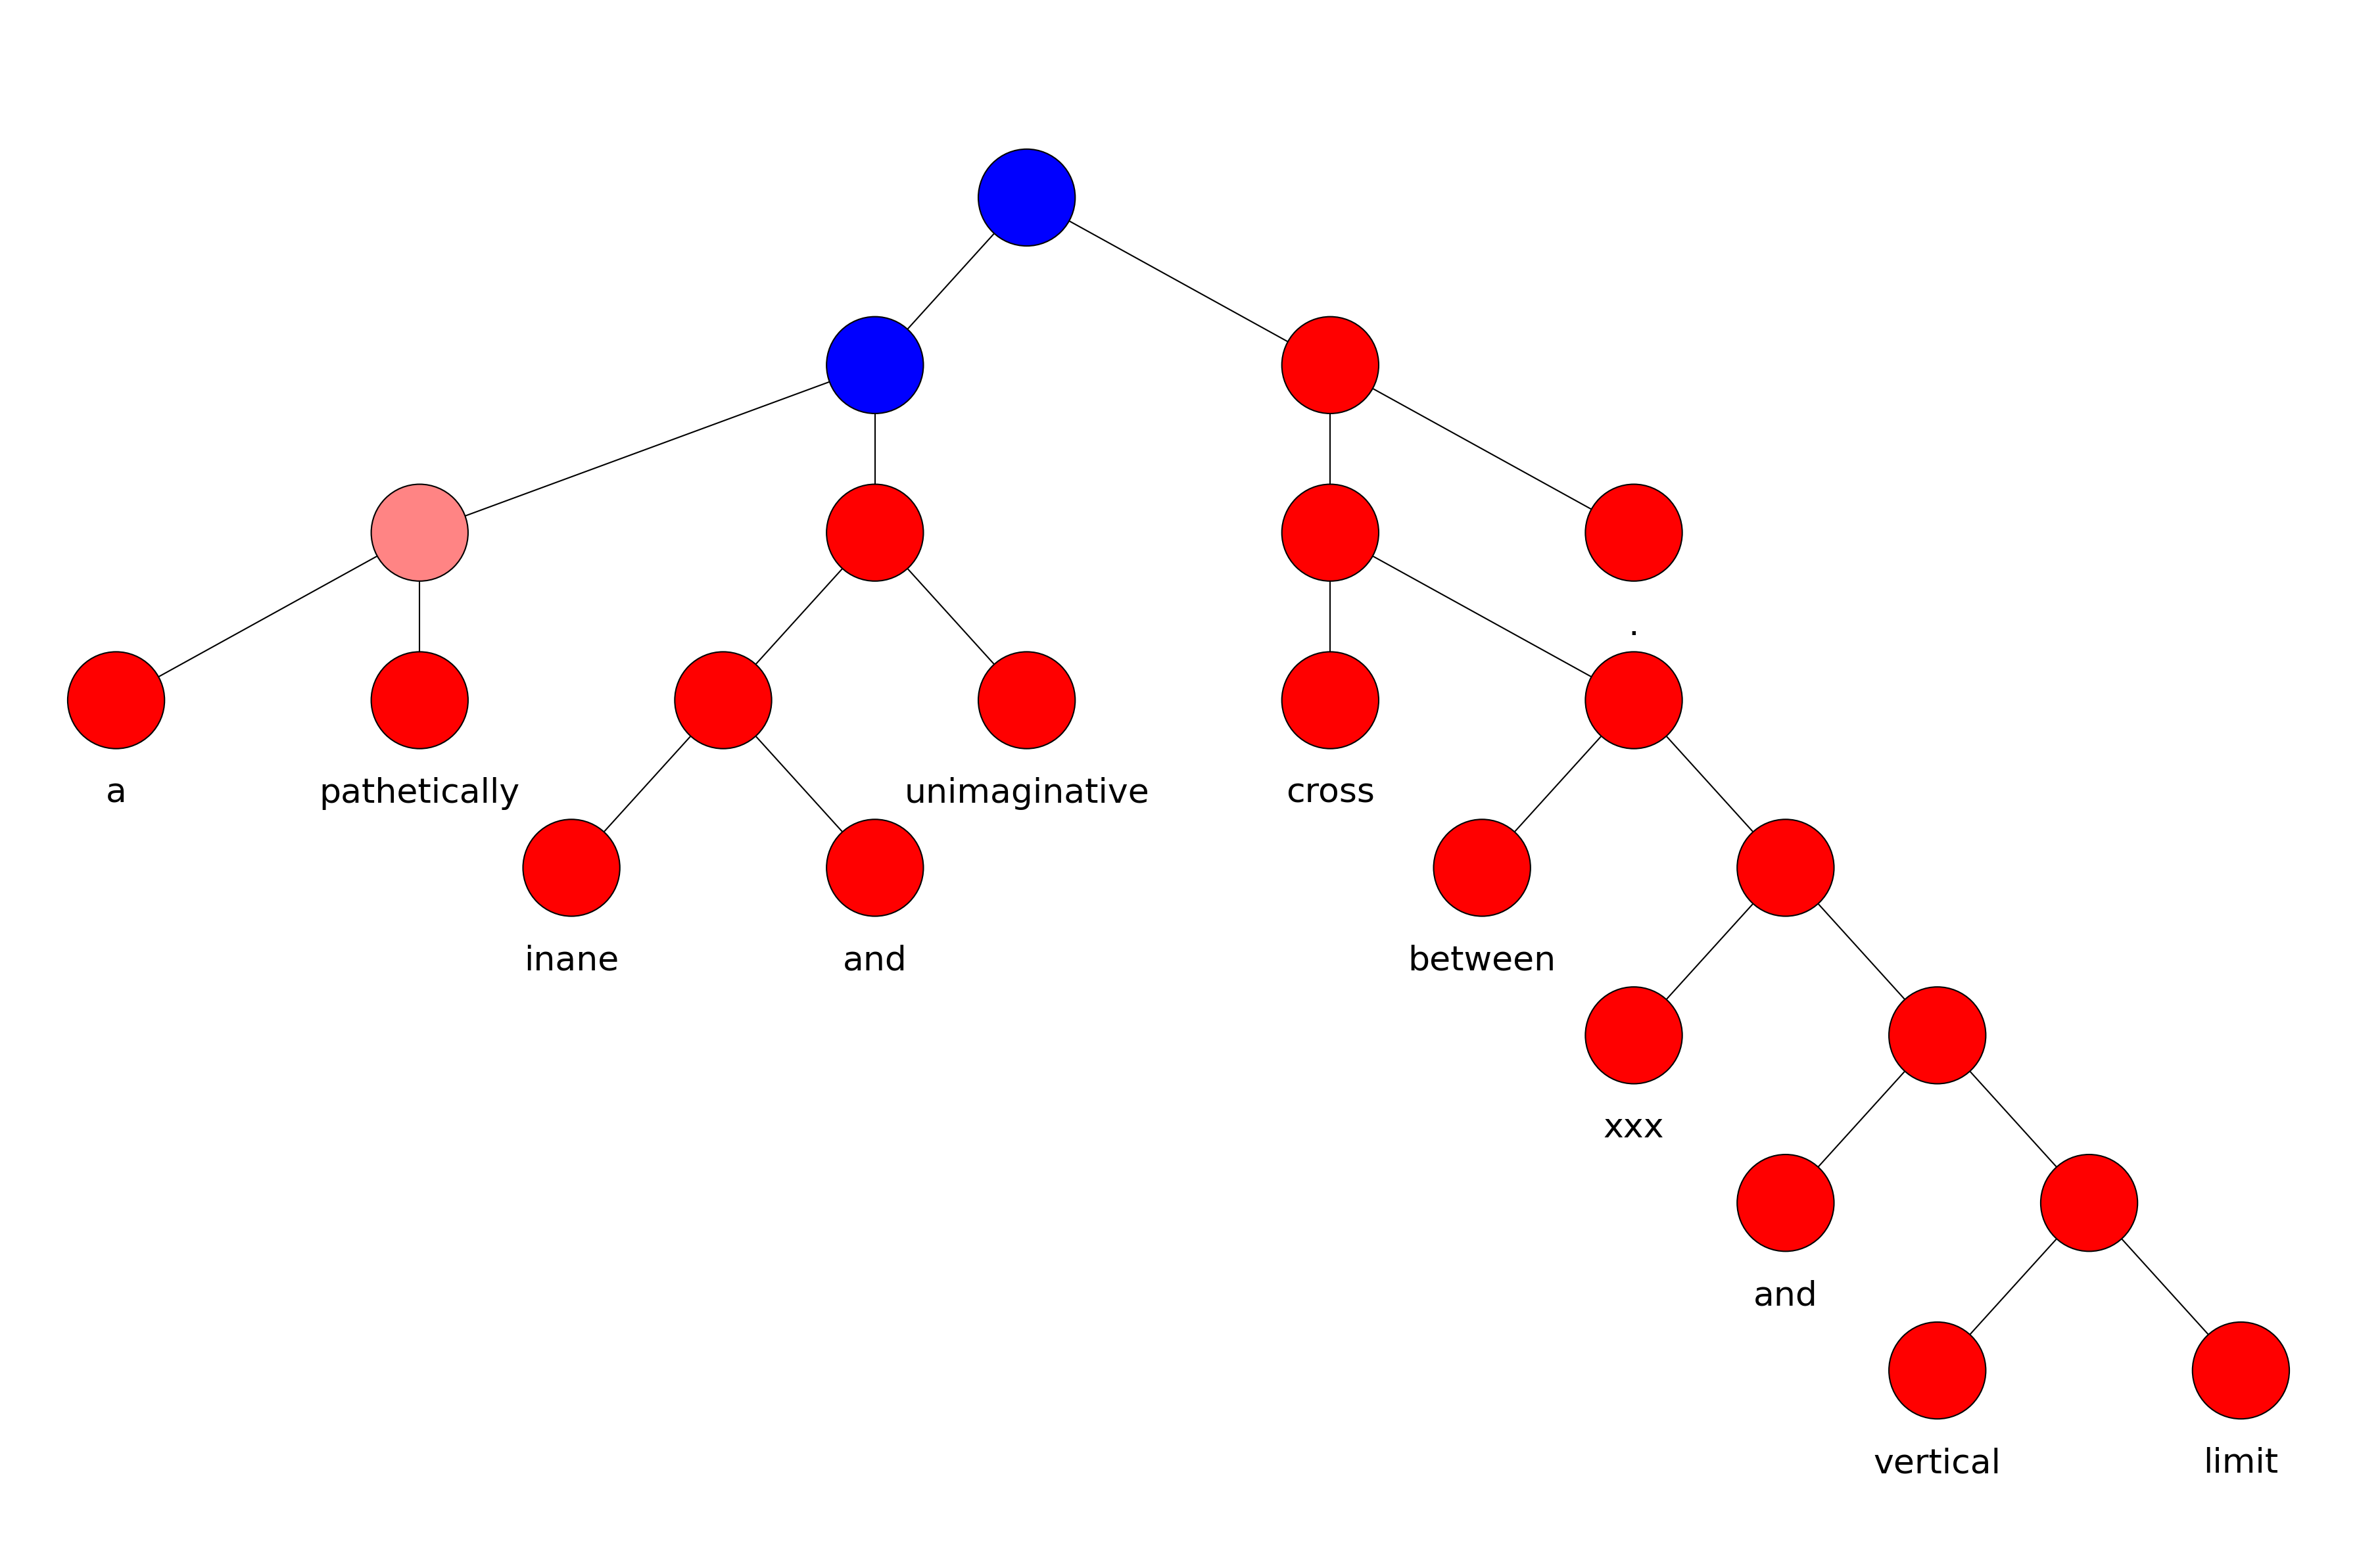

In [27]:
from lrp.queries import Mode
# plot relevance

mode = Mode.SUBSET


target = torch.tensor([-1, 1])
if False:
    target = torch.nn.functional.one_hot(
        torch.tensor(labels[0]), num_classes=2)

# explainer = TransformerSymbXAI(sample, target, model, embeddings)
explainer = BERTSymbXAI(sample, target, model, embeddings)


G = dgl.to_networkx(tree)
node_rels = {}
node_labels = {}

for node_id in range(len(labels)):
    ances = nx.ancestors(G, node_id)
    ances.add(node_id)
    
    token_set = process_treeid2tokenid(ances, mask, words, lsent, verbose=False)
    
    if 0 not in token_set:
        token_set.append(0)  # always add CLS token
        
    if mode == Mode.OR:
        # node_rels[node_id] = explainer.symb_or(token_set).item()
        node_rels[node_id] = explainer.symb_or_shap_masked(token_set, unk_embedding=unk_embedding).item()
    if mode == Mode.SUBSET:
        # node_rels[node_id] = explainer.subgraph_relevance(token_set).item()
        node_rels[node_id] = explainer.subgraph_shap_masked(token_set, unk_embedding=unk_embedding).item()
    
#     node_labels[node_id] = [explainer.words[token] for token in token_set]
    
node_heat = [make_color( rel, scaling=1) for rel in node_rels.values() ]
# node_labels = {i:round(rel,3) for i,rel in enumerate(node_rels.values()) }
node_labels = {i:round(rel,2) for i,rel in enumerate(node_rels.values()) }


if True:
    vis_tree_heat(tree, 
                  node_heat, 
                  vocab_words,
    #               node_labels=node_labels, 
                  save_dir='/home/farnoush/symbolicXAI/figures/shap_sst_qualitative2_subset_masked.png',
                 node_size=5000)
    # print(node_rels)

In [12]:
len(dataset)

2210

# Analyse how the explanation method aligns with the human annotation

In [10]:
from lrp.queries import Mode

In [13]:
unk_token_id = tokenizer.convert_tokens_to_ids('[UNK]')
cls_token_id = tokenizer.convert_tokens_to_ids('[CLS]')
sep_token_id = tokenizer.convert_tokens_to_ids('[SEP]')

# Create a tensor with the [UNK] token ID
unk_token_tensor = torch.tensor([unk_token_id]).unsqueeze(0)
print(unk_token_tensor.shape)

# Pass the tensor through the BERT model's embedding layer
unk_embedding = pretrained_embeddings(input_ids=unk_token_tensor)

torch.Size([1, 1])


In [11]:
idrange = range(200)
modes = [Mode.OR, Mode.SUBSET]
# modes = [Mode.SUBSET]
verbose = True

all_contr_or = {i: [] for i in range(5)}
all_contr_sub = {i: [] for i in range(5)}

for sid in tqdm(idrange):
    tree = dataset[sid]
    input_ids = tree.ndata['x'] # word id of the node
    labels = tree.ndata['y'] #  label of the node
    mask = tree.ndata['mask']
    lsent =  [vocab_words[idw] for idw in input_ids[mask == 1]]
    sentence =  make_text_string(lsent)
    sample = tokenizer(sentence, return_tensors="pt")
    words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())

    

    target = torch.tensor([-1, 1])

    # explainer = TransformerSymbXAI(sample, target, model, embeddings)
    explainer = BERTSymbXAI(sample, target, model, embeddings)

    G = dgl.to_networkx(tree)
    node_rels_or = {}
    node_rels_sub = {}

    # sep_token_location = torch.where(sample['input_ids'] == sep_token_id)[1].item()
    # cls_token_location = torch.where(sample['input_ids'] == cls_token_id)[1].item()

    try:
        for node_id in range(len(labels)):
            ances = nx.ancestors(G, node_id)
            ances.add(node_id)

            token_set = process_treeid2tokenid(ances, mask, words, lsent, verbose=False)

            if False:
                if cls_token_location not in token_set:
                    token_set.append(cls_token_location)  # always add CLS token
                if sep_token_location not in token_set:
                    token_set.append(sep_token_location)  # always add SEP token
            
            for mode in modes:
                if mode == Mode.OR:
                    # node_rels_or[node_id] = explainer.symb_or(token_set).item()
                    # node_rels_or[node_id] = symb_xai(all_walks_rels, token_set, mode='or')
                    # node_rels_or[node_id] = explainer.symb_or_shap(token_set).item()
                    node_rels_or[node_id] = explainer.symb_or(token_set).item()
                if mode == Mode.SUBSET:
                    # node_rels_sub[node_id] = explainer.subgraph_relevance(token_set).item()
                    # node_rels_sub[node_id] = symb_xai(all_walks_rels, token_set, mode='subset')
                    # node_rels_sub[node_id] = explainer.subgraph_shap(token_set).item()
                    node_rels_sub[node_id] = explainer.subgraph_relevance(token_set).item()
    except RuntimeError:
        if verbose: print(f'skip {sid}')
        continue
    node_labels = {i: int(label) for i,label in enumerate(labels)}
    
    assert len(node_labels.values()) == len(node_rels_or.values())
    assert len(node_labels.values()) == len(node_rels_sub.values())
    
    for label, rel in zip(node_labels.values(), node_rels_or.values()):
        all_contr_or[label].append(rel)
        
    for label, rel in zip(node_labels.values(), node_rels_sub.values()):
        all_contr_sub[label].append(rel)
    
#     node_heat = [make_color( rel, scaling=1) for rel in node_rels.values() ]


  0%|                                                   | 0/200 [02:18<?, ?it/s]

KeyboardInterrupt



In [ ]:
for i in range(10):
    print(i)

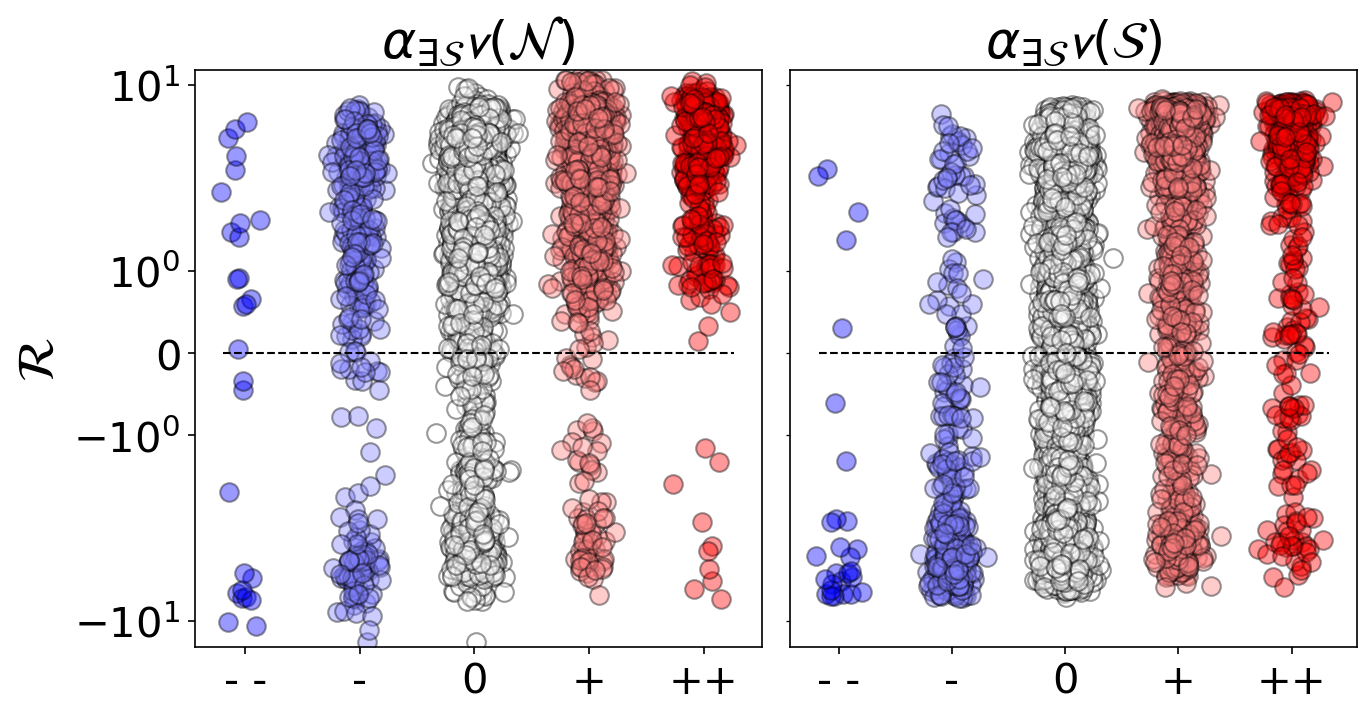

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
plt.rcParams.update({'font.size': 20})

for label, rels in all_contr_or.items():
    x = np.random.normal(loc=label, scale=.1, size=len(rels))
    axs[0].scatter(x,
                rels,
                alpha=.4, 
                edgecolors='black', 
                color=make_color(label-2, scaling=.5),
                s=80)
    
for label, rels in all_contr_sub.items():
    x = np.random.normal(loc=label, scale=.1, size=len(rels))
    axs[1].scatter(x,
                rels,
                alpha=.4, 
                edgecolors='black', 
                color=make_color(label-2, scaling=.5),
                s=80)
    
axs[0].axhline(y=0,xmin=0.05, xmax=0.95, color='black', ls='--', linewidth=1)
axs[0].set_xticks(list(label2sent_symb.keys()), list(label2sent_symb.values()), size=20)
axs[0].set_ylabel('$\\mathcal{R}$', size=25)
axs[0].set_yscale('symlog')
# axs[0].set_title('$\mathcal{R}(\\mathcal{S}^\\vee | \, \\mathcal{N})$', size=25)
axs[0].set_title('$\\alpha_{\\exists \\mathcal{S}} \\mathcal{v}(\\mathcal{N})$', size=25)

axs[1].axhline(y=0,xmin=0.05, xmax=.95, color='black', ls='--', linewidth=1)
axs[1].set_xticks(list(label2sent_symb.keys()), list(label2sent_symb.values()), size=20)
axs[1].set_yscale('symlog')
# axs[1].set_title('$\mathcal{R}(\\mathcal{S}^\\vee | \, \\mathcal{S})$', size=25)
axs[1].set_title('$\\alpha_{\\exists \\mathcal{S}} \\mathcal{v}(\\mathcal{S})$', size=25)
axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_yticks([])

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig("/home/farnoush/symbolicXAI/figures/shap_sst_dropped.png", transparent=True)
# plt.show()

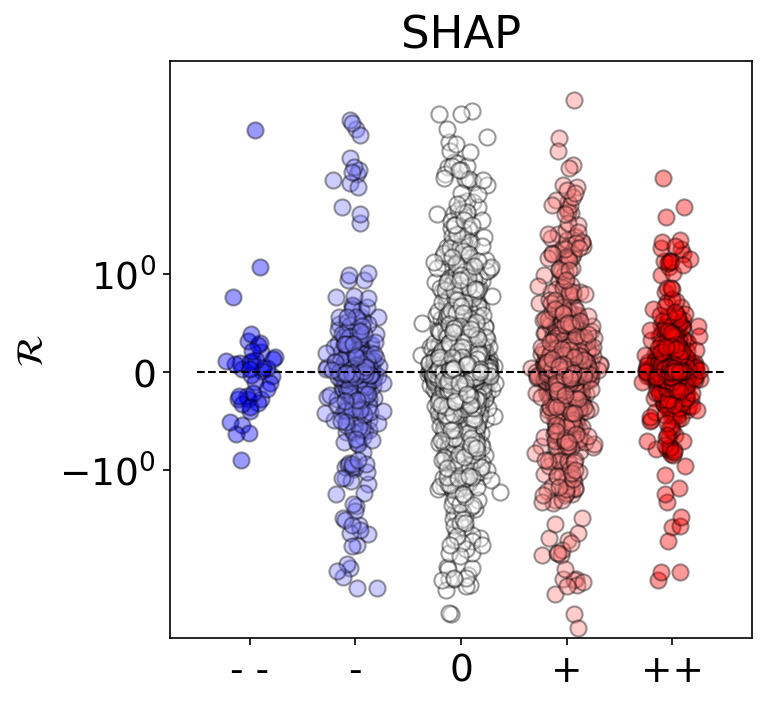

In [20]:
plt.figure(figsize=(5, 5), dpi=150)
plt.rcParams.update({'font.size': 18})

for label, rels in all_contr_sub.items():
    x = np.random.normal(loc=label, scale=.1, size=len(rels))
    plt.scatter(x, rels,
                alpha=.4, 
                edgecolors='black', 
                color = make_color(label-2, scaling=.5),
               s=60)
plt.hlines(y=0,xmin=-.5, xmax=4.5, color='black', ls='--', linewidth=1)
plt.xticks(list(label2sent_symb.keys()), list(label2sent_symb.values()))
plt.ylabel('$\\mathcal{R}$')
plt.yscale('symlog')
plt.ylim(-5,9)
plt.title('SHAP')
# plt.show()
plt.savefig("/home/farnoush/symbolicXAI/figures/shap.png", transparent=True)